# 📝 Exercise M4.04

In the previous Module we tuned the hyperparameter `C` of the logistic
regression without mentioning that it controls the regularization strength.
Later, on the slides on 🎥 **Intuitions on regularized linear models** we
metioned that a small `C` provides a more regularized model, whereas a
non-regularized model is obtained with an infinitely large value of `C`.
Indeed, `C` behaves as the inverse of the `alpha` coefficient in the `Ridge`
model.

In this exercise, we ask you to train a logistic regression classifier using
different values of the parameter `C` to find its effects by yourself.

We start by loading the dataset. We only keep the Adelie and Chinstrap classes
to keep the discussion simple.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

In [16]:
import pandas as pd

url = "https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/master/datasets/penguins_classification.csv"

penguins = pd.read_csv(url)

penguins = (
    penguins.set_index("Species").loc[["Adelie", "Chinstrap"]].reset_index()
)

culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

In [17]:
from sklearn.model_selection import train_test_split

penguins_train, penguins_test = train_test_split(
    penguins, random_state=0, test_size=0.4
)

data_train = penguins_train[culmen_columns]
data_test = penguins_test[culmen_columns]

target_train = penguins_train[target_column]
target_test = penguins_test[target_column]

We define a function to help us fit a given `model` and plot its decision
boundary. We recall that by using a `DecisionBoundaryDisplay` with diverging
colormap, `vmin=0` and `vmax=1`, we ensure that the 0.5 probability is mapped
to the white color. Equivalently, the darker the color, the closer the
predicted probability is to 0 or 1 and the more confident the classifier is in
its predictions.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay


def plot_decision_boundary(model):
    model.fit(data_train, target_train)
    accuracy = model.score(data_test, target_test)
    C = model.get_params()["logisticregression__C"]

    disp = DecisionBoundaryDisplay.from_estimator(
        model,
        data_train,
        response_method="predict_proba",
        plot_method="pcolormesh",
        cmap="RdBu_r",
        alpha=0.8,
        vmin=0.0,
        vmax=1.0,
    )
    DecisionBoundaryDisplay.from_estimator(
        model,
        data_train,
        response_method="predict_proba",
        plot_method="contour",
        linestyles="--",
        linewidths=1,
        alpha=0.8,
        levels=[0.5],
        ax=disp.ax_,
    )
    sns.scatterplot(
        data=penguins_train,
        x=culmen_columns[0],
        y=culmen_columns[1],
        hue=target_column,
        palette=["tab:blue", "tab:red"],
        ax=disp.ax_,
    )
    plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
    plt.title(f"C: {C} \n Accuracy on the test set: {accuracy:.2f}")

Let's now create our predictive model.

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logistic_regression = make_pipeline(StandardScaler(), LogisticRegression())
logistic_regression

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

## Influence of the parameter `C` on the decision boundary

Given the following candidates for the `C` parameter and the
`plot_decision_boundary` function, find out the impact of `C` on the
classifier's decision boundary.

- How does the value of `C` impact the confidence on the predictions?
- How does it impact the underfit/overfit trade-off?
- How does it impact the position and orientation of the decision boundary?

Try to give an interpretation on the reason for such behavior.

[None, None, None, None, None, None, None]

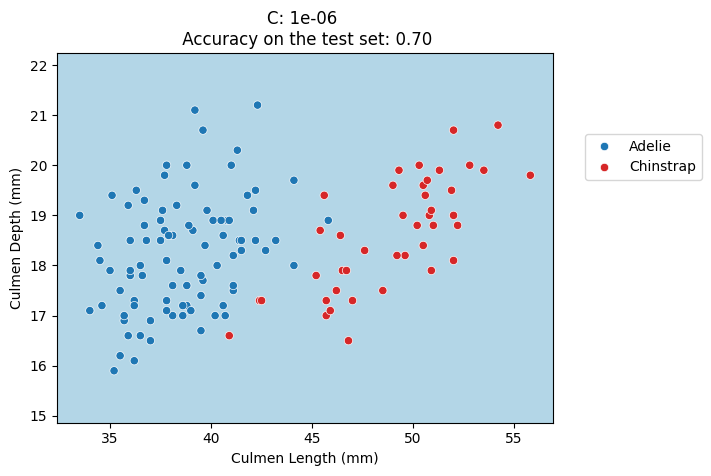

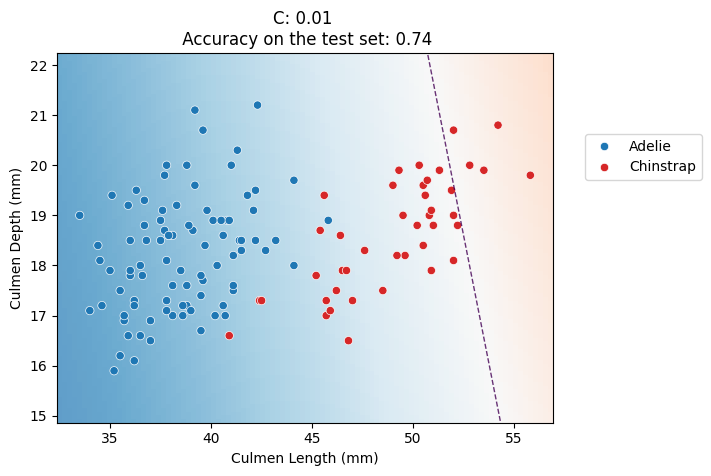

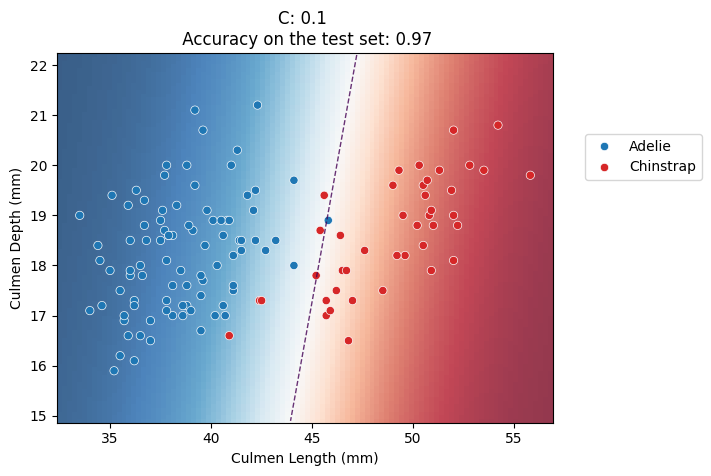

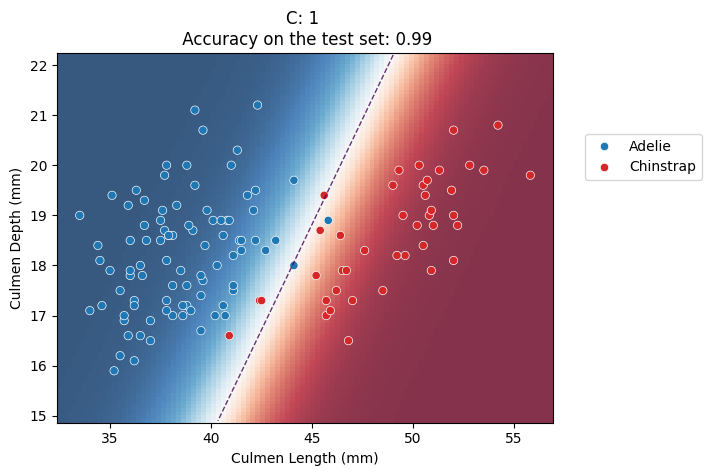

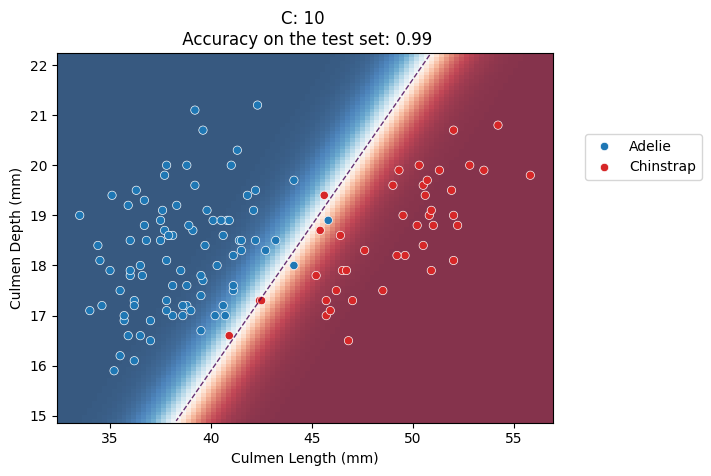

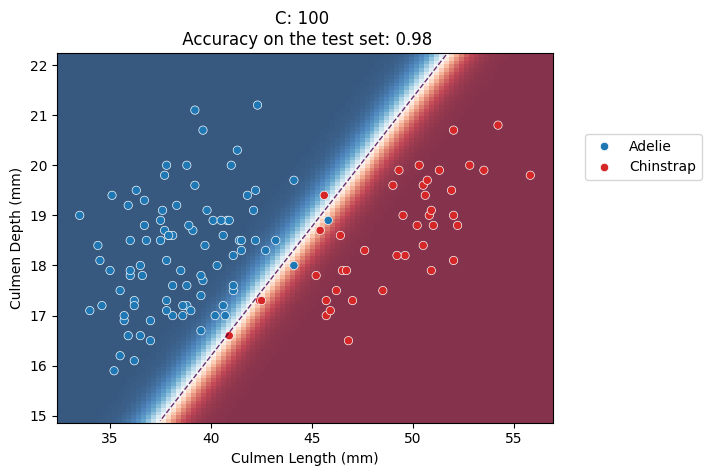

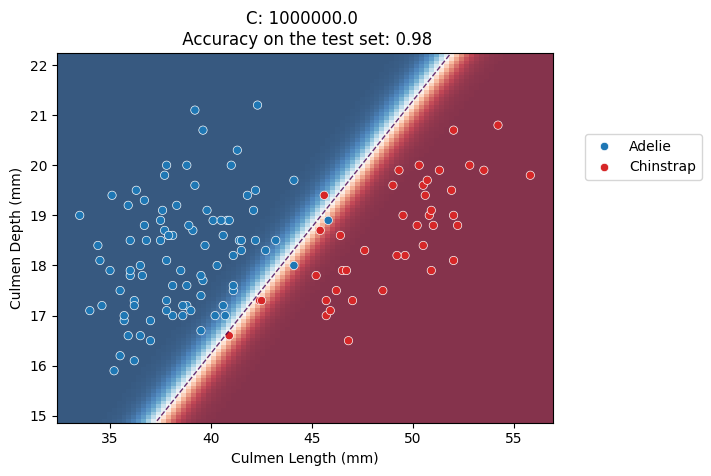

In [20]:
Cs = [1e-6, 0.01, 0.1, 1, 10, 100, 1e6]

# Write your code here.

[plot_decision_boundary(logistic_regression.set_params(logisticregression__C=C)) for C in Cs]

On this series of plots we can observe several important points. Regarding the confidence of the predictions.
- for the low values of `C` (strong regularization) the classifier s less confident in its predictions. We are enforcing a $\textbf{spread sigmoid}$
- for high value of `C`(weak regularization) the classifier is more confident: the areas with dark blue (very confident in predicting "Adelie") and dark red (very confident in predicting "Chinstrap") nearly cover the entire feature space. We are enforcing a steep sigmoid.

To answer the next question, think that misclassified data points are more costly when the classifier is more confident on the decision. Decision rules are mostly driven by avoiding such cost. From the previous observations we can then deduce that. 
- The smaller the `C` (the stronger the regularization), the lower the cost of a misclassification. As more data points lay in the low-confidence zone, the more the decision rules are influenced almost uniformly by all the data points. This leads to a less expressive model, which may underfit.
- The higher the value of `C` (the weaker the regularization), the more the decision is influences by a few training points very close to the boundary, where decisions are costly. Remember that models may overfit if the nb of samples in the training set is too samll, as at least a minimum of samples is needed to average the noise out. 

The orientation is the result of 2 factors: minimizing the nb of misclassified training points high confidence and their distance to the decision boundary (notice how the contour line tries to alogn with the most misclassified data points in the dark colored zone). This is closely related to the value of the weights of the model, which explained in the next part of the exercise.

Finally, for small values of `C`the position of the decision boundary is affected by the class imbalance: when `C` is near zero, the model predicts the majority class (as seen in the training set) everywhere in the feature space. In our case, there are approximately two times more Adelie" than "Chinstrap" penguins. This explains why the decision boundary is shifted to the right when `C` gets smaller. Indeed, the most regularized model predicts light blue almost everywhere in the feature space.

## Impact of the regularization on the weights

Look at the impact of the `C` hyperparameter on the magnitude of the weights.
**Hint**: You can [access pipeline
steps](https://scikit-learn.org/stable/modules/compose.html#access-pipeline-steps)
by name or position. Then you can query the attributes of that step such as
`coef_`.

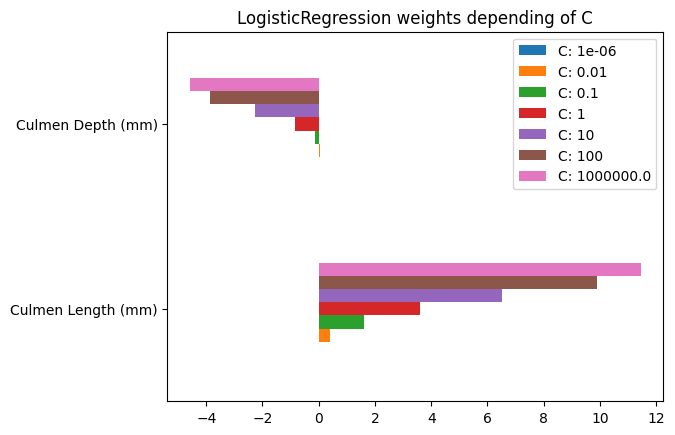

In [24]:
# Write your code here.
import numpy as np
weights = []

for C in Cs:
    logistic_regression.set_params(logisticregression__C=C).fit(data_train, target_train)
    coef = logistic_regression[-1].coef_[0]
    weights.append(pd.Series(coef, index=culmen_columns))

lr_weights = pd.concat(weights, axis=1, keys=[f"C: {C}" for C in Cs])
lr_weights.plot.barh()
_ = plt.title("LogisticRegression weights depending of C")


As small `C`provides a more regularized model, it shrinks the weights values toward zero, as in the `Ridge` model

In particular, with a strong penalty (eg `C=0.01`) the weight of the feature named "Culmen Depth (mm)" is almost zero. It explains why the decision separationn in the plot is almost perpendicular to the "Culmen Length (mm)" feature.

For even stronger penalty strengths (`C=1e-6`) the weights of both features are almost zero. It explains why the deision separation in the plot is almost constant in the feature space: the predicted probability is only based on their intercept parameter of the model (which is never regularized).

## Impact of the regularization on with non-linear feature engineering

Use the `plot_decision_boundary` function to repeat the experiment using a
non-linear feature engineering pipeline. For such purpose, insert
`Nystroem(kernel="rbf", gamma=1, n_components=100)` between the
`StandardScaler` and the `LogisticRegression` steps.

- Does the value of `C` still impact the position of the decision boundary and
  the confidence of the model?
- What can you say about the impact of `C` on the underfitting vs overfitting
  trade-off?

[None, None, None, None, None, None, None]

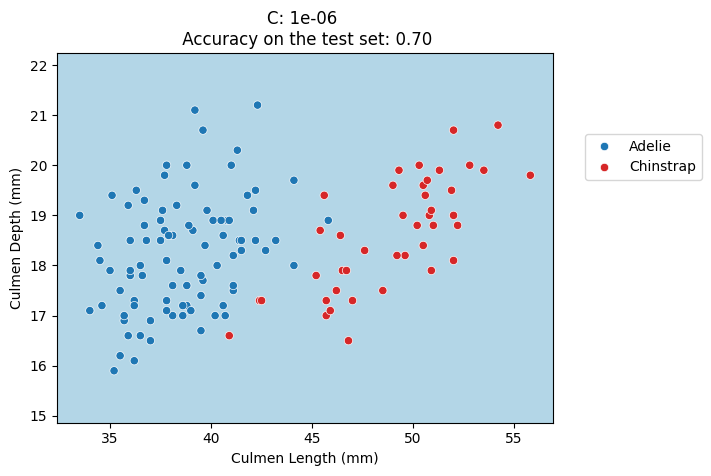

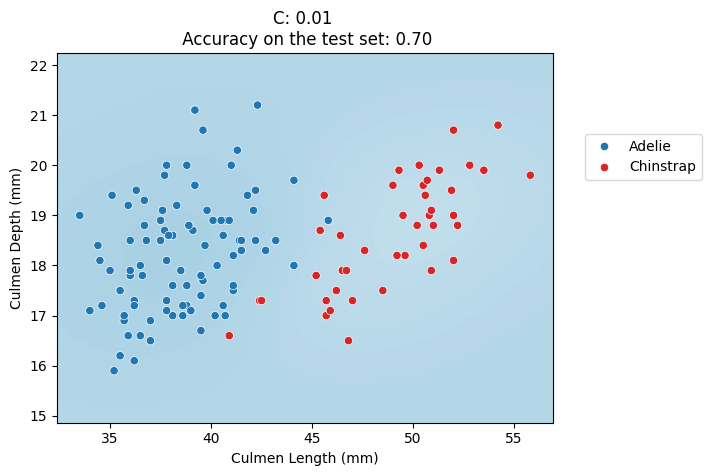

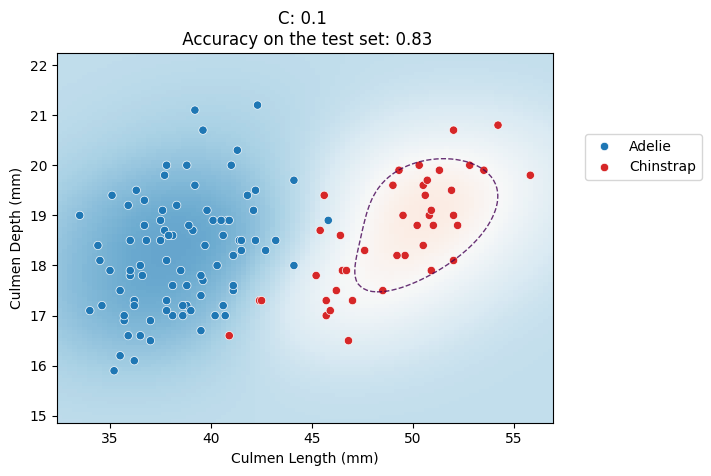

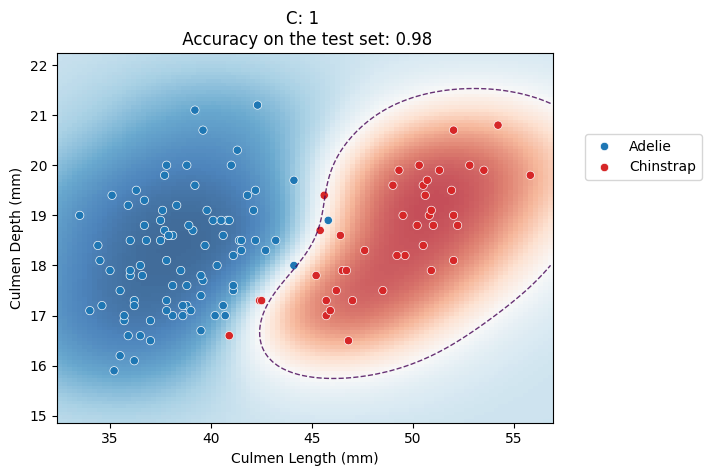

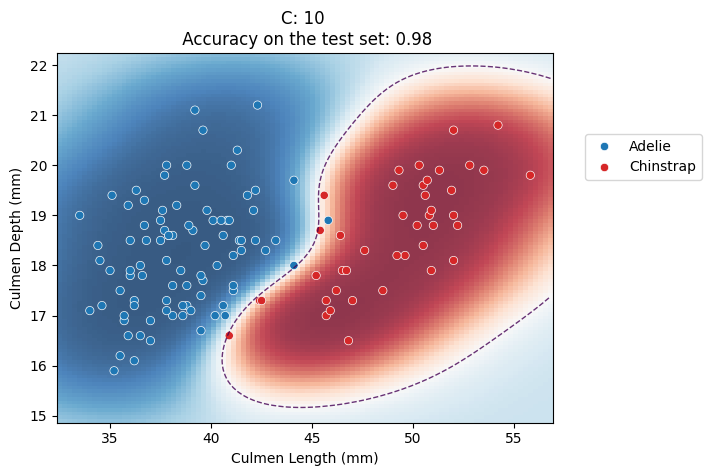

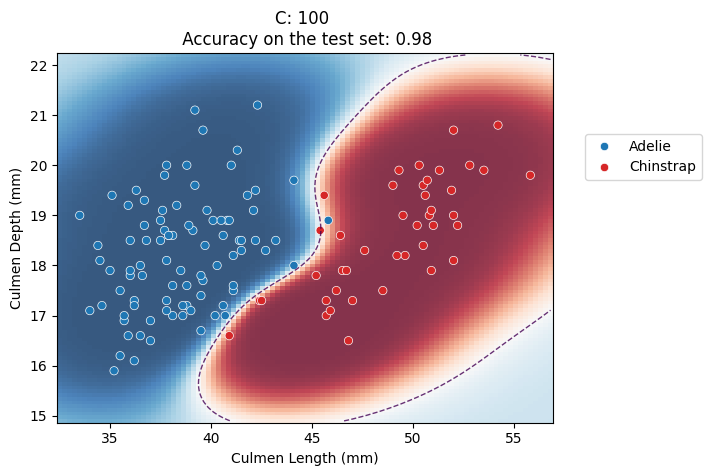

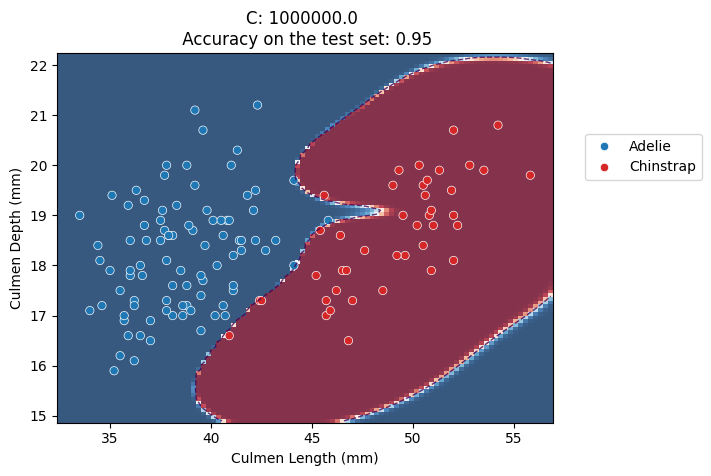

In [29]:
from sklearn.kernel_approximation import Nystroem

# Write your code here.
model = make_pipeline(
    StandardScaler(), 
    Nystroem(kernel="rbf", gamma =1, n_components=100),
    LogisticRegression()
)

[plot_decision_boundary(model.set_params(logisticregression__C=C)) for C in Cs]


- for the lowest values of `C`, the overall pipeline underfits: it predicts the majority class everywhere, as previously
- when `C` increases, the models starts to predict some datapoints from the "Chinstrap" class but the model is not very confident anywhere in the feature space.
- the decision boundary is no longer a straight line: the linear model is now classifying in the 100 dimensional feature space created by the `Nystroem` transformer. As a result, the decision boundary induced by the overall pipeline is now expressive enough to wrap around the minority class.
- for `C=1` in particular, it finds a smooth red blob around most the "Chiinstrap" data points. When moving away from the data points, the model is less confident in ts predictions and again tends to predict the majority class according to the proportion in the training set. 
- for higher values of `C`, the model starts to overfit: it is very confident in its predictions almost everywhere, but it should not be trusted: the model also makes a larger number of mistakes on the test set (not shown in the plot) while adopting a very curvy decision boundary to attempt fitting all the training points, including the noisy ones at the frontier between the two classes. This makes the decision boundary very sensitive to the sampling of the training set and as a result, it does not generalize well in that region. This is confirmed by the (slighly) lower accuracy on the test set.

Finally, we can also note that the linear model on the raw features was as good or better than the best model using non linear feature engineering. So in this case we did not really need this extra complexity in our pipeline.

To conclude, when using non linear feature engineering, it is often possible to make the pipeline overfit, even of the original feature space is low-dimensional. As a result, it is important to tune the regularization parameter in conjunction with the parameters of the transformers (tuning `gamma` would be important here). This has a direct impact on the certainty of the predictions